In [1]:
from keras.models import model_from_json, Sequential, Model
from keras.utils import np_utils
from keras.layers import LSTM, Dense , Dropout, CuDNNLSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import sys
sys.path.append("../")
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
%matplotlib inline

## Load models

In [2]:
# load learned model
generator = model_from_json(open('../models/generator_model_bp_14.json').read())
generator.load_weights('../models/generator_weight_bp_14.h5')
discriminator = model_from_json(open('../models/discriminator_model_bp_14.json').read())
discriminator.load_weights('../models/discriminator_weight_bp_14.h5')

W1004 11:05:04.336681 140268794238720 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 11:05:04.762294 140268794238720 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1004 11:05:05.209309 140268794238720 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1004 11:05:05.210211 140268794238720 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/k

## Paramset

In [3]:
batch_size = 64
input_dim = 3
seq_length = 14
latent_dim = 500
num_classes = 4
ht_ratio = 0.3

## Synthesis data

In [4]:
def generate_samples(num_samples):
    gen_x = []
    gen_y = []
    gen_iter = (num_samples // batch_size) + 1
    for i in range(0, gen_iter):
        noise = np.random.normal(0, 1, (batch_size, seq_length, latent_dim))
        sample_c = np.random.randint(0, num_classes, batch_size)
        #sample_c = np.random.binomial(1, ht_ratio, batch_size)
        sample_c = np.random.dirichlet([1,0.25,0.25,0.25], batch_size).argmax(axis = 1)
        gen_x.extend(generator.predict_on_batch([noise, sample_c]))
        gen_y.extend(sample_c)
    gen_x_arr = np.array(gen_x)
    gen_y_arr = np.array(gen_y)
    return (gen_x_arr[:num_samples], gen_y_arr[:num_samples])

In [15]:
gen_x, gen_y = generate_samples(num_samples=5753)
mms = np.load('/home/hiroshi_koshimizu/work/RCGAN/bp_data_mms.npz')
mms = ( (gen_x.reshape(gen_x.shape[0], gen_x.shape[1] * gen_x.shape[2]) + 1)/2 ) * (mms['data_max'] - mms['data_min']) + mms['data_min']
gen_x = mms.reshape( gen_x.shape[0], gen_x.shape[1], gen_x.shape[2] )
np.savez('./synthetic_bp_14.npz', x = gen_x, y = gen_y)

In [16]:
gen_y[0:40]

array([0, 2, 0, 0, 0, 0, 0, 3, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 3, 0, 1, 0,
       2, 2, 0, 1, 0, 2, 0, 0, 3, 0, 2, 0, 0, 1, 0, 0, 0, 0])

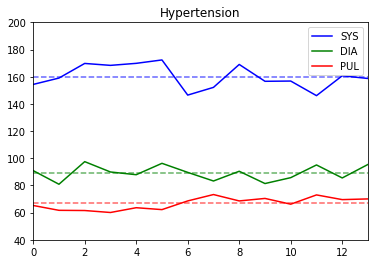

(None, 3)

In [19]:
pd.DataFrame(
    gen_x[7], 
    columns = ['SYS', 'DIA', 'PUL']
).plot(ylim = (40, 200), title = 'Hypertension', colors = ['b','g','r'])
plt.hlines(gen_x[7].mean(axis = 0), 0, 84, colors = ['b','g','r'],linestyles="dashed", alpha = 0.6)
plt.show(), gen_y[7]

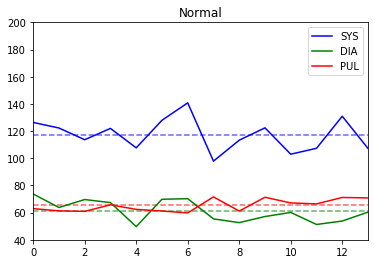

(None, 0)

In [20]:
pd.DataFrame(
    gen_x[0], 
    columns = ['SYS', 'DIA', 'PUL']
).plot(ylim = (40, 200), title = 'Normal', colors = ['b','g','r'])
plt.hlines(gen_x[0].mean(axis = 0), 0, 84, colors = ['b','g','r'],linestyles="dashed", alpha = 0.6)
plt.show(), gen_y[0]

## Read real data

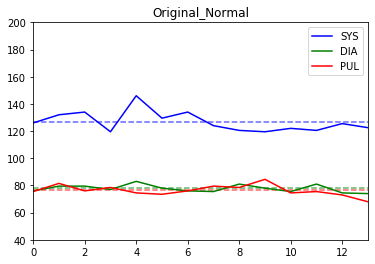

(None, 0)

In [21]:
original = np.load('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data.npz')
pd.DataFrame(
    original['x'][4], 
    columns = ['SYS', 'DIA', 'PUL']
).plot(ylim = (40, 200), title = 'Original_Normal', colors = ['b','g','r'])
plt.hlines(original['x'][4].mean(axis = 0), 0, 84, colors = ['b','g','r'], linestyles="dashed", alpha = 0.6)
plt.show(), original['y'][4]

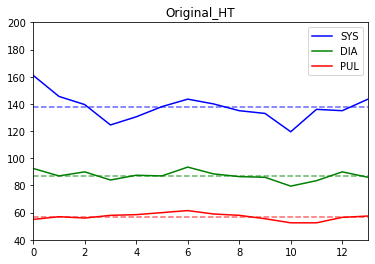

(None, 3)

In [22]:
original = np.load('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data.npz')
pd.DataFrame(
    original['x'][150], 
    columns = ['SYS', 'DIA', 'PUL']
).plot(ylim = (40, 200), title = 'Original_HT', colors = ['b','g','r','c','m','y'])
plt.hlines(original['x'][150].mean(axis = 0), 0, 84, colors = ['b','g','r','c','m','y'], linestyles="dashed", alpha = 0.6)
plt.show(), original['y'][150]

## Dist: Synthesis - Real

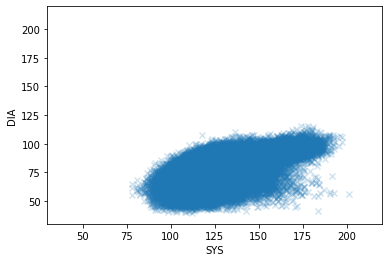

In [23]:
plt.scatter(gen_x[:,:,0].ravel(), gen_x[:,:,1].ravel(), alpha = 0.2, marker = 'x')
plt.xlabel('SYS')
plt.ylabel('DIA')
plt.xlim(30, 220)
plt.ylim(30, 220)
plt.show()

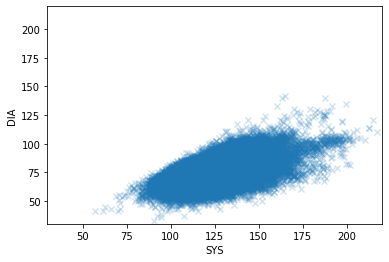

In [24]:
plt.scatter(original['x'][:,:,0].ravel(), original['x'][:,:,1].ravel(), alpha = 0.2, marker = 'x')
plt.xlabel('SYS')
plt.ylabel('DIA')
plt.ylim(30, 220)
plt.xlim(30, 220)
plt.show()

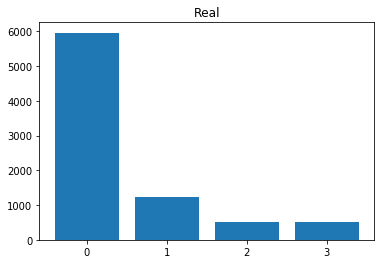

Text(0.5, 1.0, 'Sythesis')

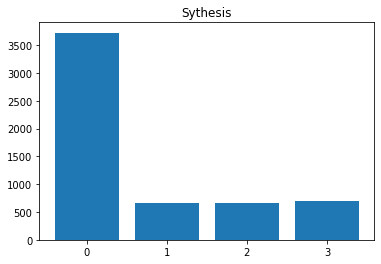

In [25]:
plt.bar(
    np.unique(original['y']).astype('str'), 
    pd.Series(original['y']).value_counts(sort = False).values,
)
plt.title('Real')
plt.show()
plt.bar(
    np.unique(gen_y).astype('str'), 
    pd.Series(gen_y).value_counts(sort = False).values,
)
plt.title('Sythesis')

## Train discremator 

In [26]:
# load synthetic data for training
npz = np.load('/home/hiroshi_koshimizu/work/RCGAN/ipynbs_koshimizu/synthetic_bp_14.npz')
X_train, y_train = npz['x'], npz['y']
print(X_train.shape)
print(y_train.shape)

# load real data for testing
npz = np.load('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data.npz')
X_eval, y_eval = npz['x'], npz['y']
X_eval, X_valid, y_eval, y_valid = train_test_split(X_eval, y_eval, test_size = 0.3)
print(X_eval.shape)
print(y_eval.shape)
print(X_valid.shape)
print(y_valid.shape)

# hyper parameter for training
input_dim = X_train.shape[2]
sequence = X_train.shape[1]
labels = 4
hidden_dim = 200

# to one-hot vector
y_train = np_utils.to_categorical(y_train, labels)
y_eval = np_utils.to_categorical(y_eval, labels)
y_valid = np_utils.to_categorical(y_valid, labels)

(5753, 14, 3)
(5753,)
(5753, 14, 3)
(5753,)
(2466, 14, 3)
(2466,)


In [27]:
model = Sequential()
model.add(CuDNNLSTM(units=hidden_dim,
               batch_input_shape=(None, sequence, input_dim),
               return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(labels, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="Adam",
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

W1004 11:06:46.944333 140268794238720 deprecation.py:506] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1004 11:06:46.967314 140268794238720 deprecation_wrapper.py:119] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [28]:
fit = model.fit(X_train, y_train,
          batch_size=64,
          epochs=30,
          validation_data=[X_valid, y_valid],
          callbacks=[early_stopping])

W1004 11:06:48.244200 140268794238720 deprecation.py:323] From /home/hiroshi_koshimizu/miniconda3/envs/gan-research/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5753 samples, validate on 2466 samples
Epoch 1/30
5753/5753 [==============================] - 1s 169us/step - loss: 0.8455 - acc: 0.6664 - val_loss: 0.4567 - val_acc: 0.8135
Epoch 2/30
5753/5753 [==============================] - 0s 75us/step - loss: 0.4015 - acc: 0.8439 - val_loss: 0.4936 - val_acc: 0.7729
Epoch 3/30
5753/5753 [==============================] - 0s 74us/step - loss: 0.3563 - acc: 0.8651 - val_loss: 0.6846 - val_acc: 0.6582
Epoch 4/30
5753/5753 [==============================] - 0s 74us/step - loss: 0.2763 - acc: 0.8967 - val_loss: 0.6590 - val_acc: 0.6910
Epoch 5/30
5753/5753 [==============================] - 0s 72us/step - loss: 0.2761 - acc: 0.8948 - val_loss: 0.4536 - val_acc: 0.7997
Epoch 6/30
5753/5753 [==============================] - 0s 71us/step - loss: 0.2341 - acc: 0.9084 - val_loss: 0.4663 - val_acc: 0.7770
Epoch 7/30
5753/5753 [==============================] - 0s 71us/step - loss: 0.2345 - acc: 0.9084 - val_loss: 0.3712 - val_acc: 0.8735
Epoch 

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1761
           1       0.51      0.79      0.62       402
           2       0.34      0.96      0.50       152
           3       0.62      0.32      0.43       151

   micro avg       0.74      0.74      0.74      2466
   macro avg       0.61      0.71      0.60      2466
weighted avg       0.85      0.74      0.77      2466
 samples avg       0.74      0.74      0.74      2466



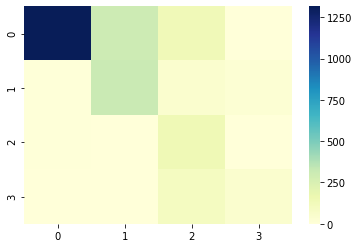

In [29]:
print(classification_report(y_valid, np_utils.to_categorical(model.predict_classes(X_valid))))

sns.heatmap(
    confusion_matrix(y_valid.argmax(axis = 1), np_utils.to_categorical(model.predict_classes(X_valid)).argmax(axis = 1)),
    cmap = 'YlGnBu'
)

In [30]:
model_o = Sequential()
model_o.add(CuDNNLSTM(units=hidden_dim,
               batch_input_shape=(None, sequence, input_dim),
               return_sequences=False))
model_o.add(Dropout(0.5))
model_o.add(Dense(labels, activation='softmax'))
model_o.compile(loss="categorical_crossentropy", optimizer="Adam",
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [31]:
fit = model_o.fit(X_eval, y_eval,
          batch_size=64,
          epochs=30,
          validation_data=[X_valid, y_valid],
          callbacks=[early_stopping])

Train on 5753 samples, validate on 2466 samples
Epoch 1/30
5753/5753 [==============================] - 1s 182us/step - loss: 0.7050 - acc: 0.7436 - val_loss: 0.4752 - val_acc: 0.8098
Epoch 2/30
5753/5753 [==============================] - 0s 75us/step - loss: 0.3673 - acc: 0.8507 - val_loss: 0.2251 - val_acc: 0.9169
Epoch 3/30
5753/5753 [==============================] - 0s 70us/step - loss: 0.3390 - acc: 0.8625 - val_loss: 0.2157 - val_acc: 0.9063
Epoch 4/30
5753/5753 [==============================] - 0s 70us/step - loss: 0.2867 - acc: 0.8848 - val_loss: 0.1697 - val_acc: 0.9534
Epoch 5/30
5753/5753 [==============================] - 0s 72us/step - loss: 0.2067 - acc: 0.9174 - val_loss: 0.1744 - val_acc: 0.9327
Epoch 6/30
5753/5753 [==============================] - 0s 73us/step - loss: 0.2316 - acc: 0.9108 - val_loss: 0.2238 - val_acc: 0.9148
Epoch 7/30
5753/5753 [==============================] - 0s 73us/step - loss: 0.1869 - acc: 0.9246 - val_loss: 0.1342 - val_acc: 0.9493
Epoch 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1761
           1       0.79      1.00      0.88       402
           2       0.97      0.85      0.91       152
           3       0.92      0.88      0.90       151

   micro avg       0.94      0.94      0.94      2466
   macro avg       0.92      0.92      0.91      2466
weighted avg       0.95      0.94      0.95      2466
 samples avg       0.94      0.94      0.94      2466



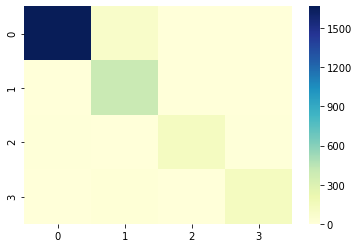

In [32]:
print(classification_report(y_valid, np_utils.to_categorical(model_o.predict_classes(X_valid))))
sns.heatmap(
    confusion_matrix(y_valid.argmax(axis = 1), np_utils.to_categorical(model_o.predict_classes(X_valid)).argmax(axis = 1)),
    cmap = 'YlGnBu'
)

## 個別確認

In [33]:
gan_chk = pd.concat(
    [
        pd.Series(y_valid.argmax(axis = 1), name = 'Real'), 
        pd.Series( 
            np_utils.to_categorical(model.predict_classes(X_valid)).argmax(axis = 1), name = 'Synthesis Trained'
        )
    ],
    axis = 1
)
gan_chk['Match'] = (gan_chk['Real'] == gan_chk['Synthesis Trained'])

In [34]:
gan_chk.groupby(['Match', 'Real']).count()

Synthesis Trained
Match Real                   
False 0                   445
      1                    85
      2                     6
      3                   102
True  0                  1316
      1                   317
      2                   146
      3                    49

In [35]:
gan_chk[
    np.logical_and(gan_chk['Real'] == 3, gan_chk['Match'] == False)
].head(10)

,Real,Synthesis Trained,Match
3,3,2,False
14,3,2,False
22,3,0,False
44,3,2,False
96,3,2,False
132,3,2,False
154,3,2,False
210,3,2,False
213,3,2,False
270,3,2,False


In [36]:
def indivi_key(index_no):
    pd.DataFrame(X_valid[index_no], columns = ['SBP', 'DBP', 'PUL']).plot(ylim = (40, 200), title = index_no)
    plt.hlines(X_valid[index_no].mean(axis = 0), 0, 14, colors = ['b', 'orange', 'green'], linestyles="dashed", alpha = 0.6)
    plt.show(), 
    print(y_valid[index_no], X_valid[index_no].mean(axis = 0))

## しきい値付近

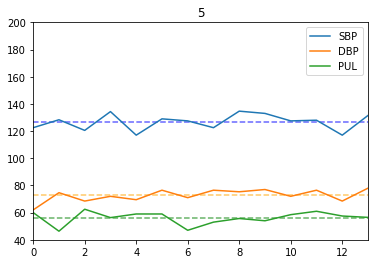

[1. 0. 0. 0.] [126.66666667  72.71428571  56.16666667]


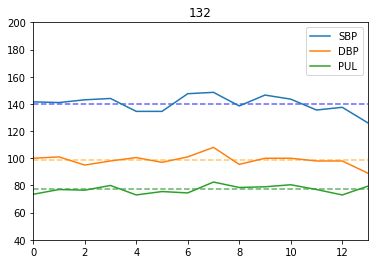

[0. 0. 0. 1.] [140.14285714  98.64285714  77.14285714]


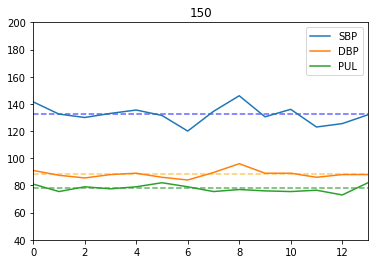

[0. 0. 1. 0.] [132.25        88.32142857  77.75      ]


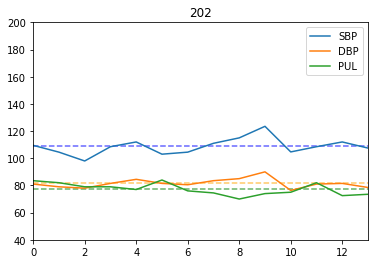

[1. 0. 0. 0.] [108.72619048  81.55952381  77.28571429]


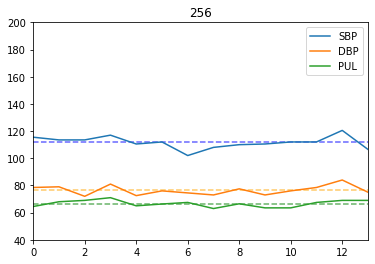

[1. 0. 0. 0.] [111.67857143  76.46428571  66.66666667]


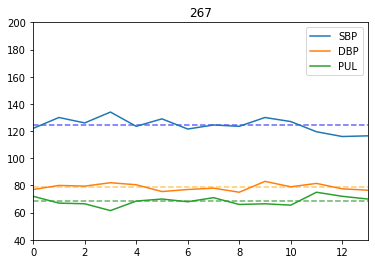

[1. 0. 0. 0.] [124.5         78.71428571  68.53571429]


In [37]:
indivi_key(5)
indivi_key(132)
indivi_key(150)
indivi_key(202)
indivi_key(256)
indivi_key(267)

## SBPが高い

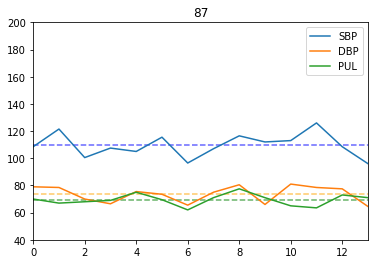

[1. 0. 0. 0.] [109.57142857  73.67857143  69.46428571]


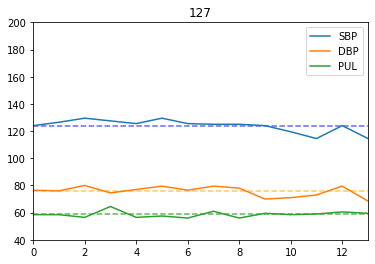

[1. 0. 0. 0.] [123.89285714  75.67857143  58.71428571]


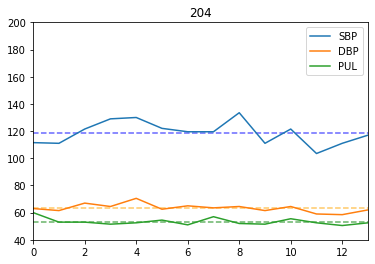

[1. 0. 0. 0.] [118.67857143  63.39285714  53.35714286]


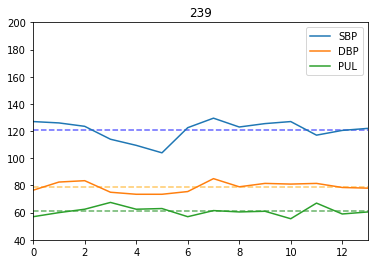

[1. 0. 0. 0.] [120.78571429  78.89285714  61.03571429]


In [38]:
indivi_key(87)
indivi_key(127)
indivi_key(204)
indivi_key(239)

極端な例と境界領域が判定ミスしやすい ⇒ 境界付近のデータがConditionをうまく付与できてない？

In [39]:
for i in zip(gen_x[:30], gen_y[:30]):
    print(i[0].mean(axis = 0), i[1])

[117.33173573  61.07200837  65.2705961 ] 0
[132.64139976  88.86858564  80.39109758] 2
[115.78321264  76.97110053  68.32278353] 0
[130.23785604  68.09136871  86.12222472] 0
[117.72278515  79.08127944  73.89953947] 0
[123.92539942  66.20415496  53.94659719] 0
[115.28017248  77.34403405  77.66541996] 0
[160.01866071  89.27568497  66.73186739] 3
[124.54856264  86.15472352  74.45629151] 2
[135.82226916  75.44090191  56.80075905] 1
[123.00194011  81.55998274  67.98719082] 0
[120.34622251  78.76486718  61.91593469] 0
[120.18927078  65.55702689  56.84203065] 0
[126.36990869  82.22568687  81.38923911] 0
[126.58974293  87.53523933  82.70226822] 2
[114.80186286  76.84815212  76.99914495] 0
[108.82109085  73.45556467  78.1597097 ] 0
[137.94893181  65.24134304  51.65224231] 1
[150.30107494  89.88704104  67.64669211] 3
[122.18798897  55.19527184  59.57801209] 0
[130.97294023  65.82209863  70.89740902] 1
[123.1220529   71.77147856  59.37948739] 0
[132.43467789  87.20632098  64.17357984] 2
[123.853657

([array([1956.,  948.,  768.,  669.,  630.,  680.,  669.,  783.,  880.,
         2017.]),
  array([4322.,  991.,  819.,  639.,  555.,  519.,  479.,  489.,  497.,
          690.]),
  array([5867.,  908.,  653.,  472.,  407.,  338.,  347.,  314.,  307.,
          387.])],
 array([1.22690332e-20, 9.99999990e-02, 1.99999998e-01, 2.99999997e-01,
        3.99999996e-01, 4.99999995e-01, 5.99999994e-01, 6.99999993e-01,
        7.99999992e-01, 8.99999991e-01, 9.99999990e-01]),
 <a list of 3 Lists of Patches objects>)

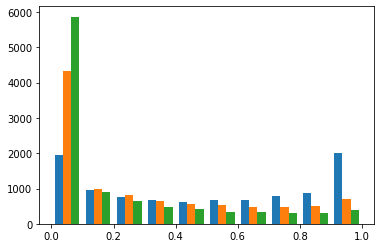

In [40]:
plt.hist(np.random.dirichlet([0.5, 0.3, 0.2], size = 10000))